In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
train_root_path = '/content/gdrive/My Drive/data/traintext/'
test_root_path = '/content/gdrive/My Drive/data/testtext/'

In [0]:
import os
dirtlist = os.lstat(train_root_path)

print(dirtlist)

os.stat_result(st_mode=16832, st_ino=37, st_dev=77, st_nlink=2, st_uid=0, st_gid=0, st_size=4096, st_atime=1569030328, st_mtime=1569029245, st_ctime=1570654163)


In [0]:
import os
dirlist = os.listdir(train_root_path)


def clean_str(text):    
  clean = list([l for l in text if l.isalpha() or l==' ']) 
  #also tried : cleaning stop words
  return "".join(clean)
 

In [0]:
#!sudo apt install tesseract-ocr
#!pip install pytesseract
import numpy as np
import pandas as pd
import pytesseract
import shutil
import os
import random
try:
  from PIL import Image
except ImportError:
  import Image

  
train_labels = pd.read_csv(train_root_path + "../train_labels.csv")
print(train_labels.head())

X = []
y = []

for file in dirlist :
  #pytesseract was used to extract text before using the provided set
  f = open(train_root_path + file, "r")
  extractedInformation = f.read()
  f.close()
  if extractedInformation != '' :
    X.append(clean_str(extractedInformation).upper())
    i = int(file.split('.')[0])
    if train_labels[train_labels["img_id"]==i]["fuel"].values == 1 :
      y.append([1,0,0,0])
    elif train_labels[train_labels["img_id"]==i]["parking"].values == 1 :
      y.append([0,1,0,0])
    elif train_labels[train_labels["img_id"]==i]["restaurant"].values == 1 :
      y.append([0,0,1,0])
    else :
      y.append([0,0,0,1])


   Unnamed: 0  img_id  fuel  parking  restaurant  transport
0           0    4209     0        1           0          0
1           1     825     0        0           1          0
2           2    2640     0        0           1          0
3           3     845     0        0           0          1
4           4     915     0        0           0          1


In [0]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.25, random_state=1000)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plt_hist(history):
    accu = history.history['acc']
    acr_val = history.history['val_acc']
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    x = range(1, len(accu) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accu, 'b', label='Training accu')
    plt.plot(x, acr_val, 'r', label='Validation accu')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, loss_val, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9934
Testing Accuracy:  0.9005


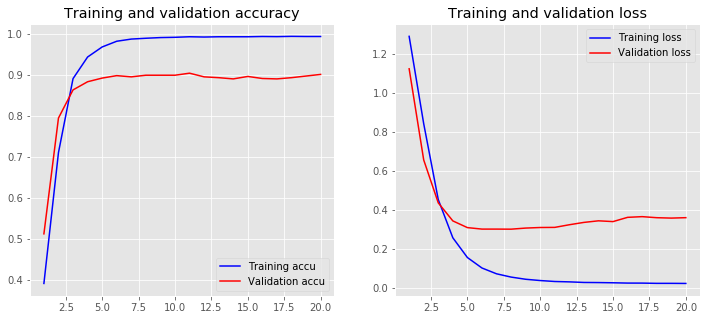

In [0]:
#!pip install keras

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

from keras.preprocessing.sequence import pad_sequences

maxlen = 1000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


from keras.models import Sequential
from keras import layers


embedding_dim = 50 #tried values : 30,50,100 the best one was chosen

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu')) #tried values : 10,20,40 the best one was chosen
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

"""  this model was not so accurate   

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
"""

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10) #tried values 4,10,20 the best one was chosen
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plt_hist(history)

In [0]:
import os
dirlist = os.listdir(test_root_path)

X = []
for file in dirlist :
  f = open(test_root_path + file, "r")
  extractedInformation = f.read()
  f.close()
  if extractedInformation != '' :
    X.append(clean_str(extractedInformation).upper())

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=maxlen)    
prediction = model.predict(np.array(X))



submission = []
for i in range(len(prediction)):
  submission.append([dirlist[i].split('.')[0], prediction[i][0], prediction[i][1], prediction[i][2], prediction[i][3]])

df = pd.DataFrame(data=submission, columns=['img_id','fuel','parking','restaurant','transport'])
print(df)
df.to_csv("submission4.csv", index=False)
!cp submission*.csv /content/gdrive/My\ Drive/data